# Inferring Measurement Error of ∆F From Wild-Type Measurements

© 2018 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [104]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import mut.viz
import mut.thermo
import mut.stats
import mut.bayes
import matplotlib.pyplot as plt
import tqdm 
import seaborn as sns
mut.viz.plotting_style()
colors = mut.viz.color_selector('mut')
pboc = mut.viz.color_selector('pboc')
constants = mut.thermo.load_constants()

In [105]:
# Load the induction paper data
data = pd.read_csv('../../data/csv/RazoMejia2018_data.csv')
data['repressors'] *= 2
data.rename(columns={'fold_change_A':'fold_change',
                    'IPTG_uM':'IPTGuM'}, inplace=True)
data = data[data['repressors'] > 0].copy()

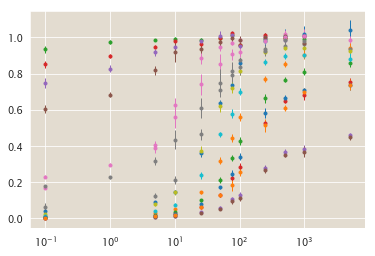

In [106]:
repressor_colors = {22:pboc['red'], 60: pboc['green'], 124:pboc['purple'], 260:pboc['blue'], 1220:pboc['yellow'], 1740:'dodgerblue'}
for g, d in data.groupby(['operator', 'repressors']):
    _d = d.groupby(['IPTGuM']).agg(('mean', 'sem')).reset_index()
    plt.errorbar(_d['IPTGuM'], _d['fold_change']['mean'], _d['fold_change']['sem'],
                 lw=1, capsize=0, linestyle='none',fmt='.')
plt.xscale('log')


In [107]:
# Compute the reference bohr for each measurement. 
ref_bohr = mut.thermo.SimpleRepression(R=data['repressors'], ep_r=data['binding_energy'],
                                      ka=constants['Ka'], ki=constants['Ki'], 
                                      ep_ai=constants['ep_AI'], effector_conc=data['IPTGuM']).bohr_parameter()
data['ref_bohr'] = ref_bohr

In [109]:
# Load the stan model. 
model = mut.bayes.StanModel('../stan/empirical_F.stan')

Found precompiled model. Loading...
finished!


In [152]:
# Loop through each unique repressor, operator, and IPTG and calculate the ∆F. 
dbohr_stats = []
for g, d in tqdm.tqdm(data.groupby(['repressors', 'operator', 'IPTGuM'])):
    ref = d['ref_bohr'].values[0]
    fc_ref = (1 + np.exp(-ref))**-1
    data_dict = {'N':len(d), 'ref_bohr':d['ref_bohr'].values[0],
                'foldchange':d['fold_change']}
    fit, samples = model.sample(data_dict, iter=5000, control=dict(adapt_delta=0.9)) 
    samples['empirical_bohr'] = -np.log((samples['fc_mu'])**-1 - 1)
    samples['delta_bohr'] = ref - samples['empirical_bohr']
    
    # Identify the extrema 
    extrema = (samples['fc_mu'] < samples['fc_sigma']).astype(int) + (1 - samples['fc_mu'] < samples['fc_sigma']).astype(int)
    
    # Compute the delta F error of the reference, given the sigma
    delta_F_ref_upper = np.nan_to_num(ref + np.log((fc_ref + samples['fc_sigma'])**-1 - 1))
    delta_F_ref_lower = np.nan_to_num(ref + np.log((fc_ref - samples['fc_sigma'])**-1 - 1))
    samples['correction'] = (delta_F_ref_upper-delta_F_ref_lower) * extrema
    samples['delta_bohr_corrected'] = samples['delta_bohr'] + np.sign(ref) * samples['correction'] 
    
    # Compute the stats. 
    stats = mut.stats.compute_statistics(samples, varnames=['fc_mu', 'empirical_bohr', 'delta_bohr', 'fc_sigma',
                                                           'delta_bohr_corrected', 'correction'],
                                        logprob_name='lp__')
    stats['ref_bohr'] = d['ref_bohr'].values[0]
    stats['repressors'] = g[0]
    stats['operator'] = g[1]
    stats['IPTGuM'] = g[2]    
    dbohr_stats.append(stats)
dbohr = pd.concat(dbohr_stats)

  3%|▎         | 6/216 [00:03<01:53,  1.85it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
100%|██████████| 216/216 [01:42<00:00,  2.11it/s]


In [150]:
dbohr.to_csv('../../data/csv/RazoMejia2018_delta_F_statistics.csv', index=False)

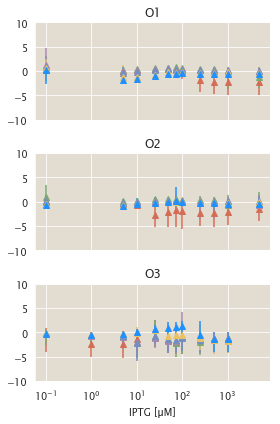

In [153]:
fig, ax = plt.subplots(3, 1, figsize=(4, 6), sharex=True, sharey=True)
axes = {'O1':ax[0], 'O2':ax[1], 'O3':ax[2]}
for g, d in dbohr.groupby(['operator', 'repressors']):
    _ax = axes[g[0]]

    # Compute the error function. 
    fc = d[d['parameter']=='fc_mu']
    bohr = d[d['parameter']=='empirical_bohr'] 
    upper = np.abs(fc['hpd_max'] - fc['median'])
    lower = np.abs(fc['hpd_min'] - fc['median'])
    mu = fc['median']
    delta = d[d['parameter']=='delta_bohr']
    delta_corr = d[d['parameter']=='delta_bohr_corrected']
    

#     _ax.plot(bohr['IPTGuM'], delta['median'], color=repressor_colors[g[1]], marker='.', linestyle='none')
#     _ax.vlines(bohr['IPTGuM'], delta['hpd_min'], delta['hpd_max'], color=repressor_colors[g[1]])
     
    _ax.plot(bohr['IPTGuM'], delta_corr['median'], color=repressor_colors[g[1]], marker='^', linestyle='none')
    _ax.vlines(bohr['IPTGuM'], delta_corr['hpd_min'], delta_corr['hpd_max'], color=repressor_colors[g[1]])
   
titles = ['O1', 'O2', 'O3']
for i, a in enumerate(ax):
    a.set_xscale('log')
    a.set_title(titles[i])
    a.set_ylim([-10, 10])
ax[-1].set_xlabel('IPTG [µM]')  
plt.tight_layout()

In [136]:
pboc

{'green': '#7AA974',
 'light_green': '#BFD598',
 'pale_green': '#DCECCB',
 'yellow': '#EAC264',
 'light_yellow': '#F3DAA9',
 'pale_yellow': '#FFEDCE',
 'blue': '#738FC1',
 'light_blue': '#A9BFE3',
 'pale_blue': '#C9D7EE',
 'red': '#D56C55',
 'light_red': '#E8B19D',
 'pale_red': '#F1D4C9',
 'purple': '#AB85AC',
 'light_purple': '#D4C2D9',
 'dark_green': '#7E9D90'}